In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

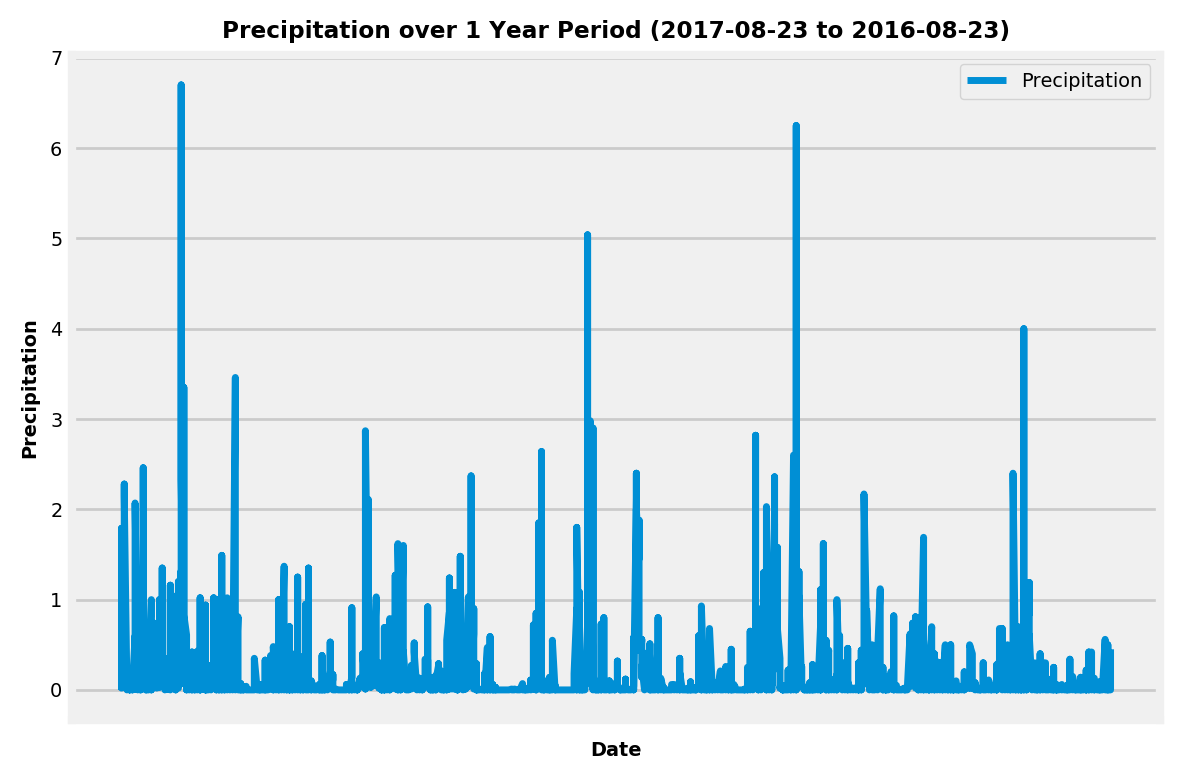

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
end_date = dt.datetime.strptime(latest_date, '%Y-%m-%d').date()
start_date = dt.datetime.strftime(end_date - dt.timedelta(days=365),'%Y-%m-%d')
start_date


# Perform a query to retrieve the data and precipitation scores
rain_data = session.query(Measurement.date, Measurement.prcp)\
            .filter(func.strftime('%Y-%m-%d', Measurement.date) >= start_date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain_data)
rain_df = rain_df.set_index('date')


# Sort the dataframe by date
rain_df = rain_df.sort_values(by='date')
rain_df = rain_df.dropna()
rain_df


# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.dpi'] = 200
fig, rain = plt.subplots()

rain.plot(rain_df.index, rain_df['prcp'], linewidth=2.5, label='Precipitation', zorder=2)

plt.legend(fontsize='x-small', loc='best')
plt.title(f'Precipitation over 1 Year Period ({latest_date} to {start_date})', fontsize='small', weight='bold')
plt.xlabel('Date', fontsize='x-small', weight='bold')
plt.ylabel('Precipitation', fontsize='x-small', weight='bold')
plt.yticks(fontsize='x-small')
rain.set_xticklabels([])
rain.xaxis.grid(False, which='both')

plt.tight_layout()
plt.savefig('Output/Precipitation.png')

plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data

rain_summary = rain_df.describe()
rain_summary

# Alternatively:
# rain_summary = rain_df['prcp'].agg('describe')[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
# rain_summary = rain_df.agg('describe')[{'prcp':['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']}]
# rain_summary = rain_summary.rename(columns={'prcp':'precipitation'})
# rain_summary

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stn_activity = session.query(Measurement.station, func.count(Measurement.station))\
               .group_by(Measurement.station)\
               .order_by(func.count(Measurement.station)\
               .desc())\
               .all()
stn_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stn_most_active = stn_activity[0][0]
stn_most_active

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

stn_summary = session.query(*sel).filter(Measurement.station == stn_most_active).all()
stn_summary

[(54.0, 85.0, 71.66378066378067)]

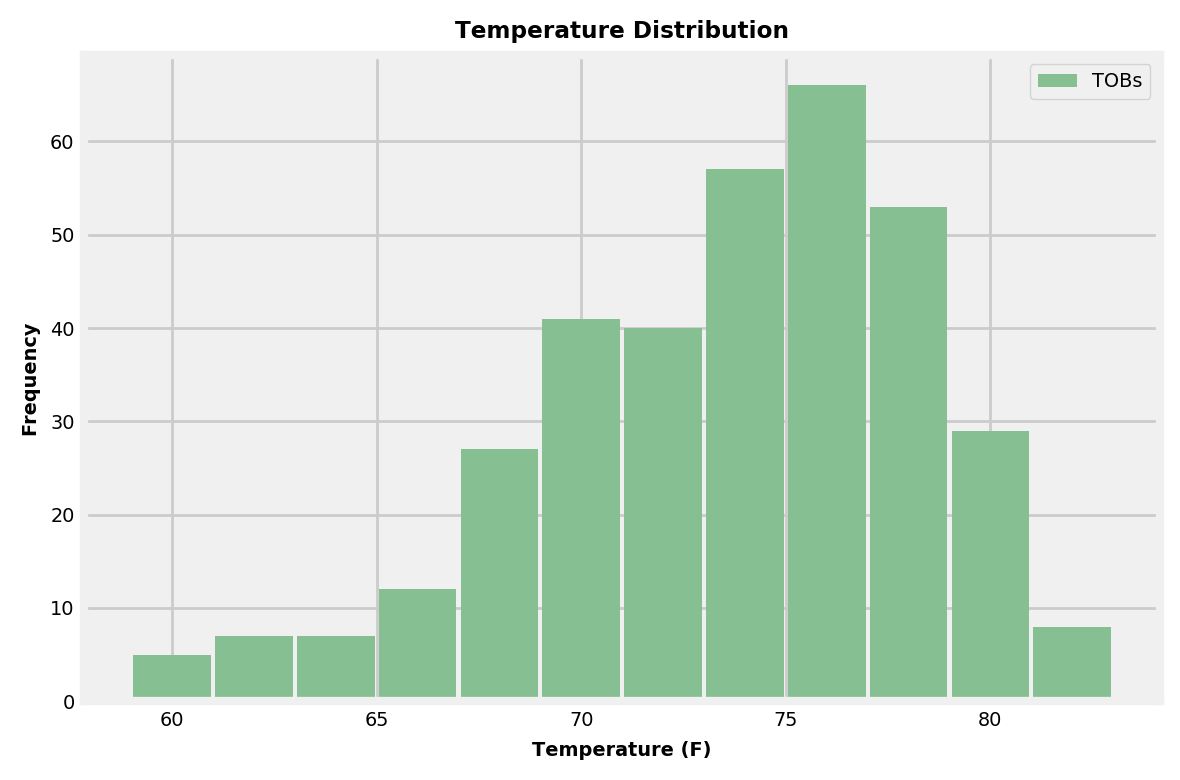

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs)\
            .filter(Measurement.station == stn_most_active)\
            .filter(func.strftime('%Y-%m-%d', Measurement.date) >= start_date)\
            .all()

temp_df = pd.DataFrame(temp_data)

plt.rcParams['figure.dpi'] = 200
fig, temp = plt.subplots()

temp.hist(temp_df['tobs'], bins=12, color='#86bf91', rwidth=0.95, label='TOBs', zorder=2)

plt.legend(fontsize='x-small', loc='best')
plt.title(f'Temperature Distribution', fontsize='small', weight='bold')
plt.xlabel('Temperature (F)', fontsize='x-small', weight='bold')
plt.ylabel('Frequency', fontsize='x-small', weight='bold')
plt.xticks(fontsize='x-small')
plt.yticks(fontsize='x-small')


plt.tight_layout()
plt.savefig('Output/Temperature.png')

plt.show()

# Optional Analysis: Temperature Analysis I

In [16]:
# Query for stations
results = session.query(Measurement.station).distinct().all()

stations = [results[i][0] for i in range(len(results))]
stations_df = pd.DataFrame(stations, columns=['station'])
stations_df

,station
0,USC00519397
1,USC00513117
2,USC00514830
3,USC00517948
4,USC00518838
5,USC00519523
6,USC00519281
7,USC00511918
8,USC00516128


In [17]:
# Query for June and December temperature measurements
sel = [Measurement.station, Measurement.date, Measurement.tobs]
june_data = session.query(*sel).filter(func.strftime("%m", Measurement.date) == '06').all()
dec_data = session.query(*sel).filter(func.strftime("%m", Measurement.date) == '12').all()

In [18]:
june_df = pd.DataFrame(june_data)
june_df.head()

,station,date,tobs
0,USC00519397,2010-06-01,78.0
1,USC00519397,2010-06-02,76.0
2,USC00519397,2010-06-03,78.0
3,USC00519397,2010-06-04,76.0
4,USC00519397,2010-06-05,77.0


In [19]:
dec_df = pd.DataFrame(dec_data)
dec_df.head()

,station,date,tobs
0,USC00519397,2010-12-01,76.0
1,USC00519397,2010-12-03,74.0
2,USC00519397,2010-12-04,74.0
3,USC00519397,2010-12-06,64.0
4,USC00519397,2010-12-07,64.0


In [20]:
# Calculate paired t-test for each station
stats_summary = stations_df.copy()

for row in range(len(stations_df)):
    (t_stat, p) = ttest_ind(june_df.loc[june_df['station'] == stations_df.iloc[row,0]]['tobs'],
                            dec_df.loc[dec_df['station'] == stations_df.iloc[row,0]]['tobs'])
    stats_summary.loc[row, 't-test'] = t_stat
    stats_summary.loc[row, 'p-value'] = p
    
    if p < 0.05:
        stats_summary.loc[row, 'significance'] = 'statistically significant'
    else:
        stats_summary.loc[row, 'significance'] = 'not statistically significant'

stats_summary

,station,t-test,p-value,significance
0,USC00519397,24.502392,1.702579e-84,statistically significant
1,USC00513117,12.512461,4.925108e-31,statistically significant
2,USC00514830,8.810087,5.285692e-17,statistically significant
3,USC00517948,12.162471,3.807657e-27,statistically significant
4,USC00518838,1.214596,2.297091e-01,not statistically significant
5,USC00519523,14.799538,1.652719e-40,statistically significant
6,USC00519281,10.520187,2.701116e-23,statistically significant
7,USC00511918,9.258554,3.301662e-18,statistically significant
8,USC00516128,9.958899,3.791431e-21,statistically significant


#### Results


In [21]:
# Calculate paired t-test for all June and December data points regardless of station
(t_stat, p) = ttest_ind(june_df['tobs'], dec_df['tobs'])

print(f't-stat = {t_stat}, p-value = {p}')

if p < 0.05:
    print('Difference is statistically significant')
else:
    print('Difference is not statistically significant')

t-stat = 31.60372399000329, p-value = 3.9025129038616655e-191
Difference is statistically significant


### Results

Paired t-tests were performed as the data analyzed were collected/measured at the same stations over different periods of time.

Analysis 1: T-tests were performed for measurements at each station.  For eight of the nine stations, the differences in average temperatures between June and December where found to be statistically significant (i.e., p-values were less than 0.05).

Analysis 2: A T-test was performed for all June and December measurements.  With a p-value of less than 0.05, the difference in mean temperatures between June and December was found to be statistically significant.

# Optional Analysis: Temperature Analysis II

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
previous_year_start = '2017-03-15'
previous_year_end = '2017-03-22'

results = calc_temps(previous_year_start, previous_year_end)

t_min = results[0][0]
t_ave = results[0][1]
t_max = results[0][2]

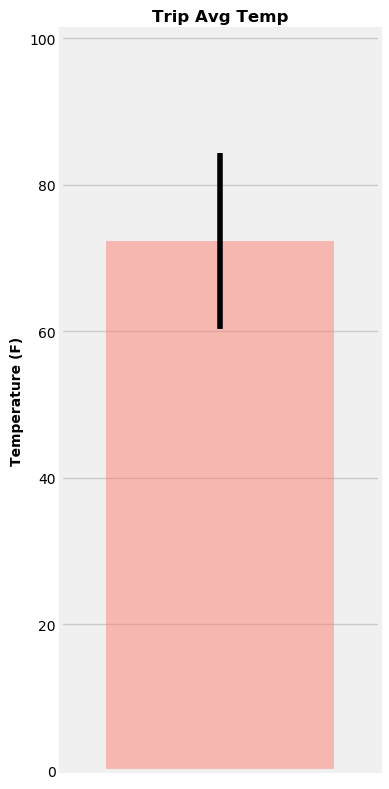

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.rcParams['figure.dpi'] = 100
fig, vacation = plt.subplots(figsize=plt.figaspect(2.))

vacation.bar(1, t_ave, yerr=t_max-t_min, color='salmon', alpha=.5)

plt.title('Trip Avg Temp', fontsize='large', weight='bold')
plt.ylabel('Temperature (F)', fontsize='medium', weight='bold')
plt.yticks(fontsize='medium')
vacation.set_xticklabels([])
vacation.xaxis.grid(False, which='both')
vacation.margins(.2, .2)

plt.tight_layout()
plt.savefig('Output/Vacation_Temperature.png')

plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Target period: 2017-03-15 to 2017-03-22

sel = [func.sum(Measurement.prcp), 
       Measurement.station, 
       Station.name, 
       Station.latitude, 
       Station.longitude, 
       Station.elevation]

vacation_rain = session.query(*sel)\
                .filter(Measurement.station == Station.station)\
                .filter(func.strftime('%Y-%m-%d', Measurement.date) >= previous_year_start)\
                .filter(func.strftime('%Y-%m-%d', Measurement.date) <= previous_year_end)\
                .group_by(Station.station)\
                .order_by(func.sum(Measurement.prcp).desc())\
                .all()

vacation_df = pd.DataFrame(vacation_rain, columns=['total prcp','station','name','latitude','longitude', 'elevation'])
vacation_df

,total prcp,station,name,latitude,longitude,elevation
0,0.35,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,0.29,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,0.19,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,0.06,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,0.00,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
5,0.00,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
6,0.00,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


# Optional Analysis: Daily Normals

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set vacation dates
vacation_start = '2020-03-15'
vacation_end = '2020-03-22'

# Determine length of vacation
time_delta = dt.datetime.strptime(vacation_end,'%Y-%m-%d') - dt.datetime.strptime(vacation_start,'%Y-%m-%d')
vacation_length = time_delta.days + 1

# Use the start and vacation length to create a range of dates
base = dt.datetime.strptime(vacation_start,'%Y-%m-%d')
vacation_range = [dt.datetime.strftime((base + dt.timedelta(days=i)).date(),'%m-%d') for i in range(vacation_length)]
vacation_range

# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = [daily_normals(day)[0] for day in vacation_range]
normals_list

[(58.0, 68.54716981132076, 76.0),
 (60.0, 69.70370370370371, 78.0),
 (57.0, 68.54, 75.0),
 (57.0, 67.7843137254902, 76.0),
 (60.0, 69.1, 75.0),
 (62.0, 70.11764705882354, 80.0),
 (60.0, 71.07692307692308, 77.0),
 (65.0, 71.75471698113208, 77.0)]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
base = dt.datetime.strptime(vacation_start,'%Y-%m-%d')
trip_dates = [dt.datetime.strftime((base + dt.timedelta(days=i)).date(),'%Y-%m-%d') for i in range(vacation_length)]
trip_dates

normals_df = pd.DataFrame(normals_list, columns=['min temp', 'ave temp', 'max temp'], index=trip_dates)
normals_df

,min temp,ave temp,max temp
2020-03-15,58.0,68.547170,76.0
2020-03-16,60.0,69.703704,78.0
2020-03-17,57.0,68.540000,75.0
2020-03-18,57.0,67.784314,76.0
2020-03-19,60.0,69.100000,75.0
2020-03-20,62.0,70.117647,80.0
2020-03-21,60.0,71.076923,77.0
2020-03-22,65.0,71.754717,77.0


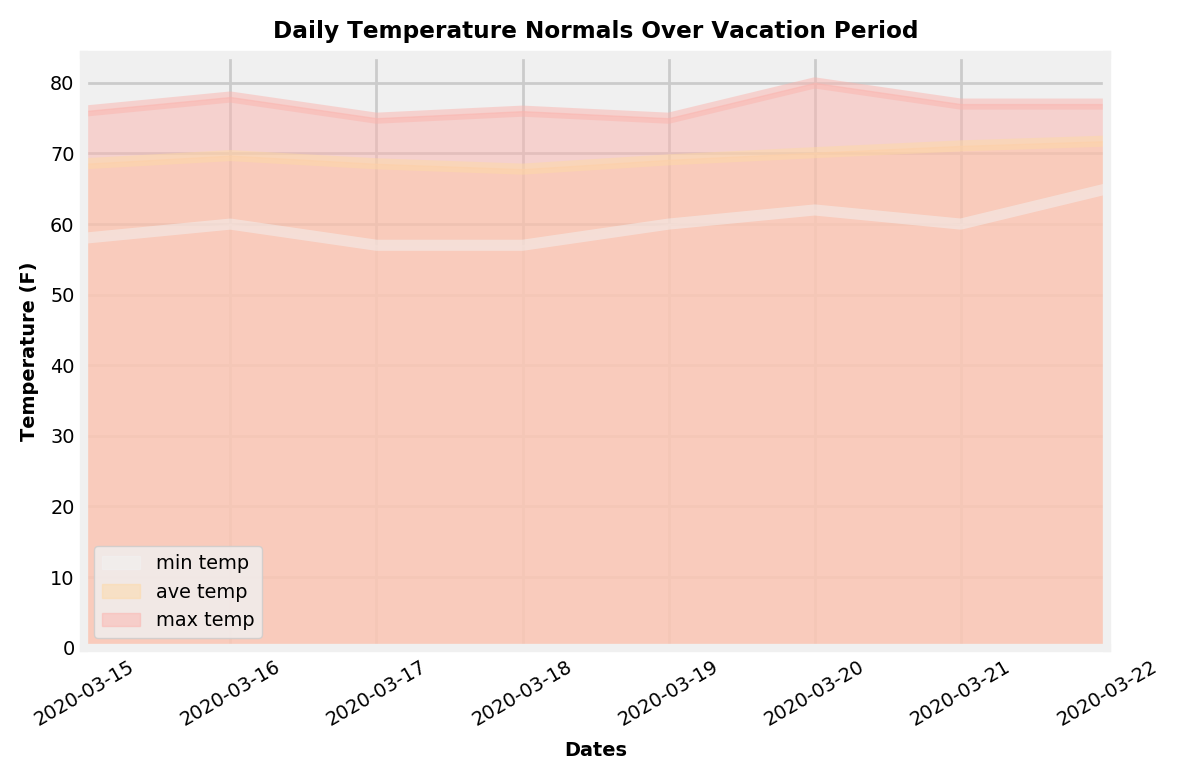

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
plt.rcParams['figure.dpi'] = 200

normals_df.plot(kind='area', stacked=False, colormap='Pastel1_r')

plt.legend(fontsize='x-small', loc='best')
plt.title(f'Daily Temperature Normals Over Vacation Period', fontsize='small', weight='bold')
plt.xlabel('Dates', fontsize='x-small', weight='bold')
plt.ylabel('Temperature (F)', fontsize='x-small', weight='bold')
plt.xticks(fontsize='x-small', rotation=30)
plt.yticks(fontsize='x-small')

plt.tight_layout()
plt.savefig('Output/DailyNormals.png')

plt.show()